# Bayesian Inference 1: Project Report

### Title: "The project title"

### Name: "The Author name"


## Abstract

> _Writing a short summary of your methods and the significant of your results, a succinct abstract is an art_

## Introduction

Introduce your dataset, then the related problem or the question, and the hypothesis for solving the issues.

Bonus point of your could provide short information of other approaches to the same problem

Introduce your method for building the model, short explain why given method is selected, what is it merits

Some text about the code packages you are going to use for the project (which language and libraries are used)

What is the goal you want to achieve after finishing the project

* Solving the specific problem
* Learn how to build probabilistic model for real world tasks
* ...

## Methods

Short description of which methods have been used for processing the data, building the model and doing the inference


### Dataset description and processing

What are the variables in the given dataset?

Are they random variable or deterministic variable? What are their distributions? 

What is the relation between the variable, 

* which one is observed ?
* which one is target variable ?
* which one is latent variable ?
* How all these variables could be linked to solve our problem ?

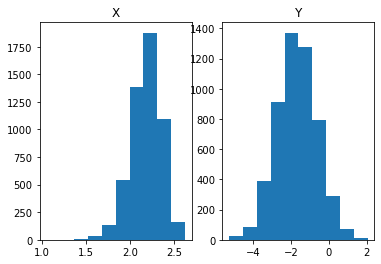

In [1]:
# plot the variable distribution with some preprocessing here to 
# support your assumption and hypothesis,  but don't be
# restricted to this code, you should think about relevant way
# of explaining your own hypothesis

import numpy as np
import matplotlib.pyplot as plt

x = 1.5 * np.random.randn(5218) + 8
x = np.log1p(x)
y = np.random.rand(5218) - x + np.random.randn(5218)
plt.subplot(1, 2, 1)
plt.hist(x)
plt.title("X")
plt.subplot(1, 2, 2)
plt.hist(y)
_ = plt.title("Y")

### Model description

Defining the generative process

Writing the pseudo-programe for generating the data, then visualizing it with graphical model

Specify all the distributions and their parameters

Write down the joint probability equation of the model

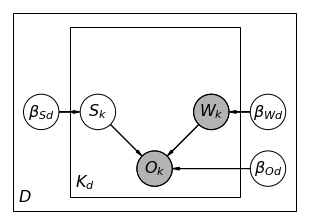

In [2]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('segregation', r'$S_k$', 0, 2, scale=scale, observed=False)
pgm.add_node('orthodox', r'$O_{k}$', 1, 1, scale=scale, observed=True)
pgm.add_node('income', r'$W_k$', 2, 2, scale=scale, observed=True)
# pgm.add_node('density', r'$P_k$', 1, 3, scale=scale, observed=True)
pgm.add_node('beta_S', r'$\beta_{Sd}$', -1, 2, scale=scale, observed=False)
pgm.add_node('beta_W', r'$\beta_{Wd}$', 3, 2, scale=scale, observed=False)
pgm.add_node('beta_O', r'$\beta_{Od}$', 3, 1, scale=scale, observed=False)

pgm.add_edge('beta_S', 'segregation', directed=True)
pgm.add_edge('beta_W', 'income', directed=True)
pgm.add_edge('beta_O', 'orthodox', directed=True)
# pgm.add_edge('density', 'segregation', directed=True)
# pgm.add_edge('density', 'income', directed=True)
pgm.add_edge('segregation', 'orthodox', directed=True)
pgm.add_edge('income', 'orthodox', directed=True)

pgm.add_plate([-0.5, 0.5, 3, 3], r'$K_d$')
pgm.add_plate([-1.5, 0.25, 5, 3.5], r'$D$')

pgm.render()

$O_{k}$: the proportion of Russian Orthodox population in location k

$W_{k}$: income per person in location k

$S_{k}$: the proportion of Russian Orthodox population in location k without income differences

$D$: districts

$K_d$: locations in district d

$ \beta_{d} \sim \begin{pmatrix} \end{pmatrix} $:


### Inference Method

Defining the inference process, drawing the graphical model of the inference

Which method are used for inferring the latent variables?

How to building the model programmatically (coding ...)?

C:\Users\antth\Anaconda3\envs\bayes\lib\site-packages\geopandas\plotting.py:589: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


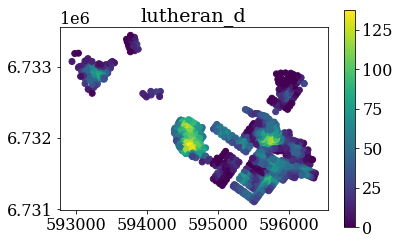

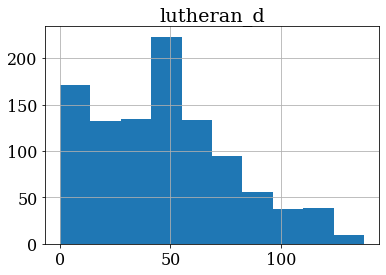

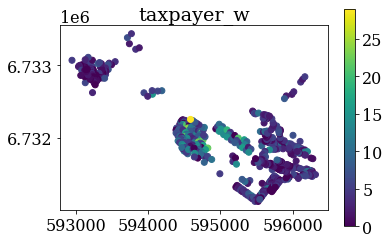

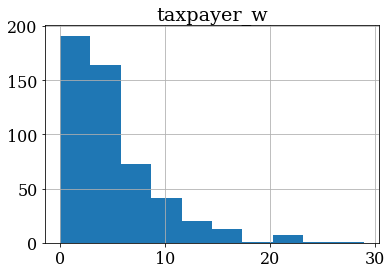

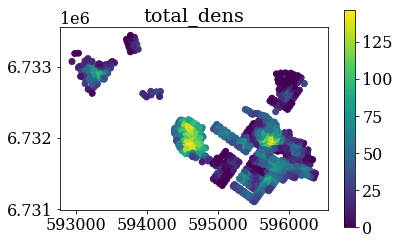

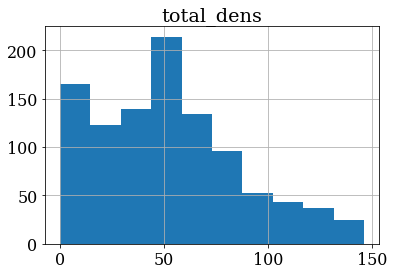

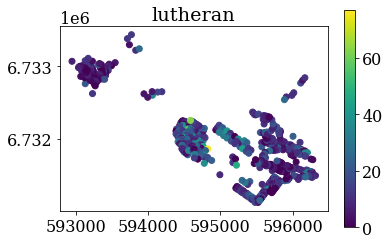

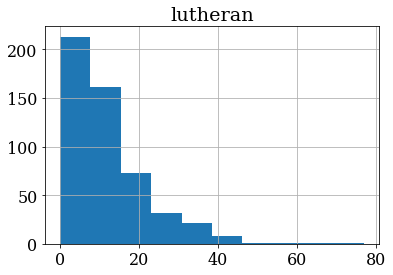

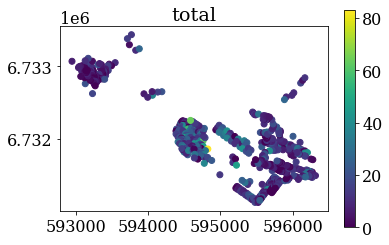

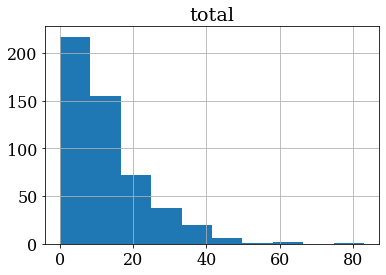

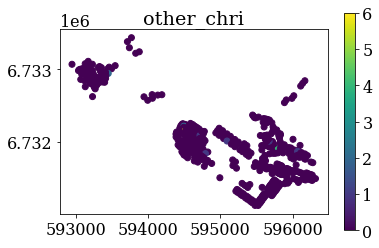

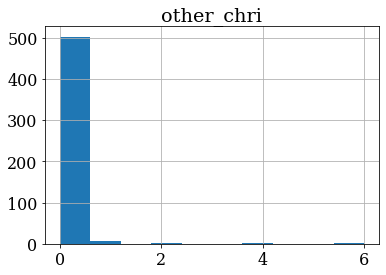

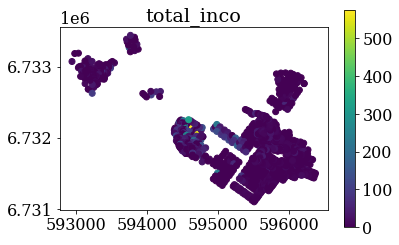

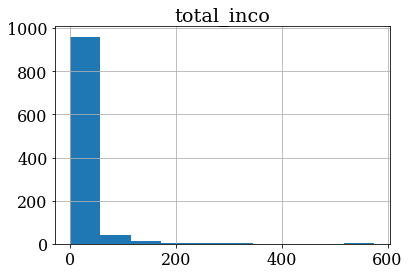

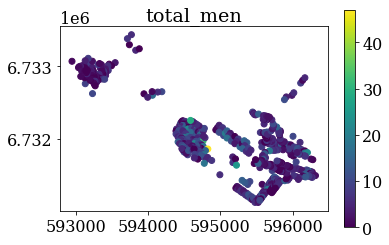

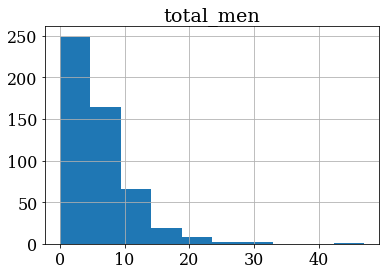

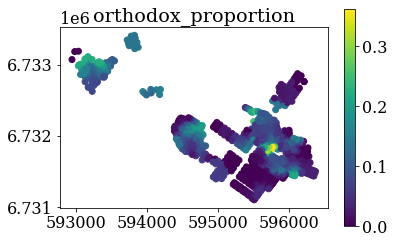

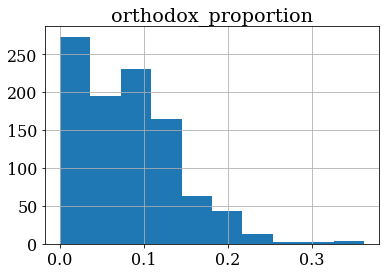

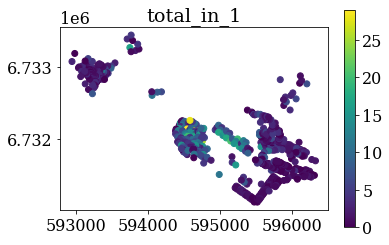

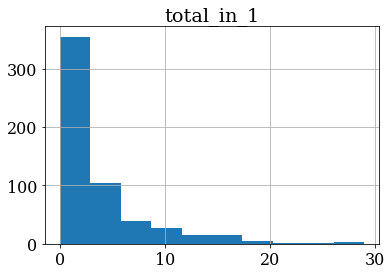

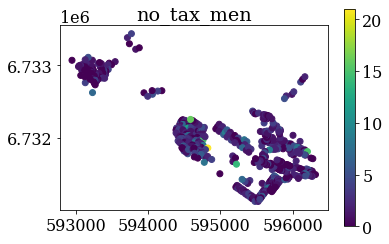

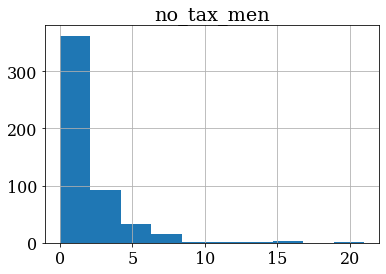

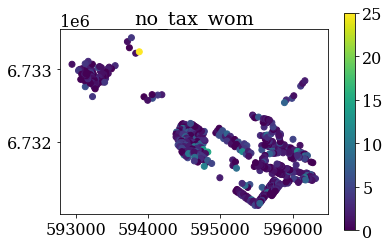

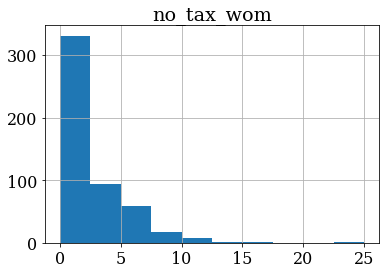

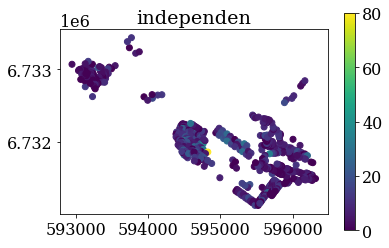

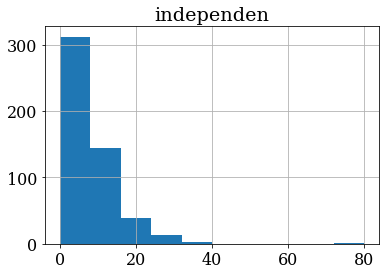

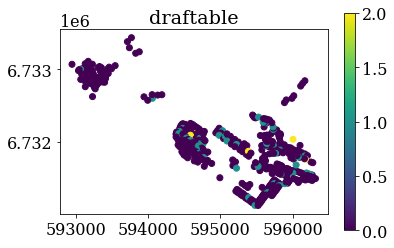

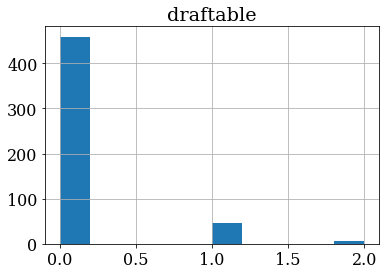

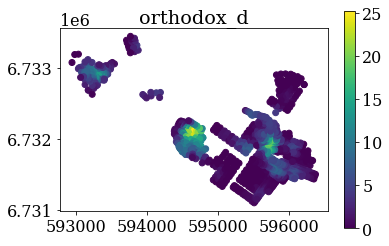

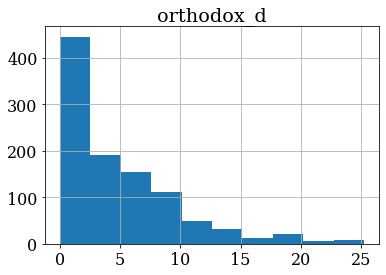

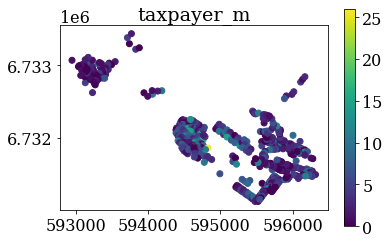

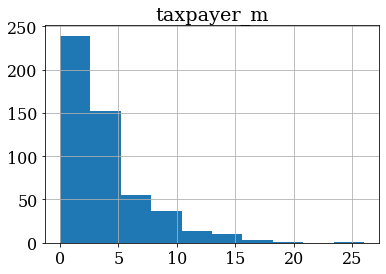

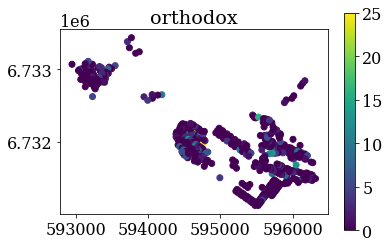

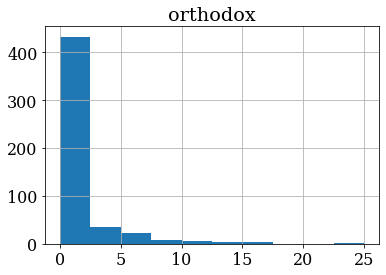

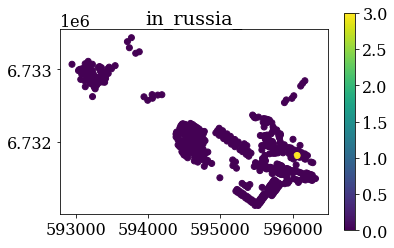

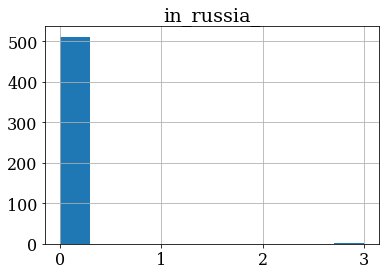

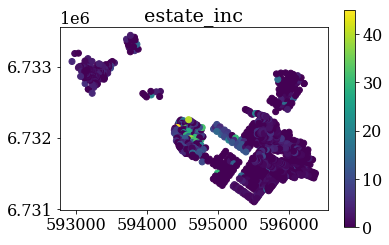

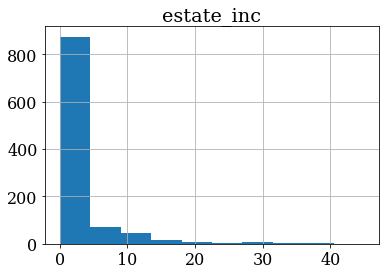

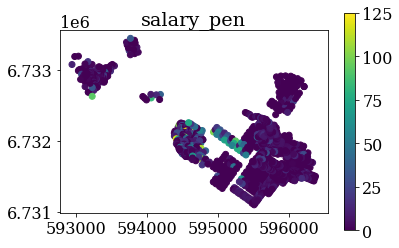

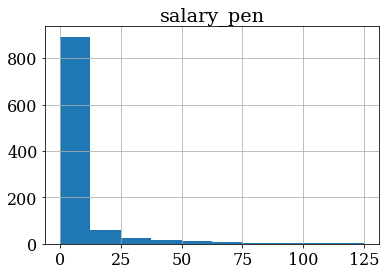

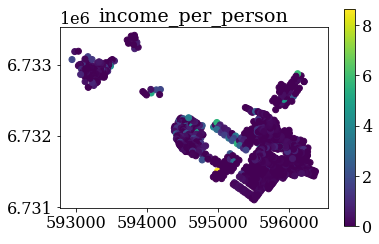

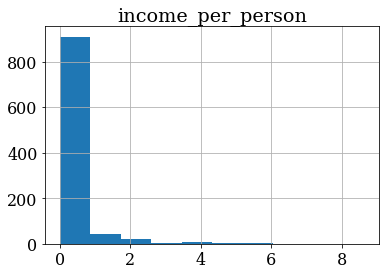

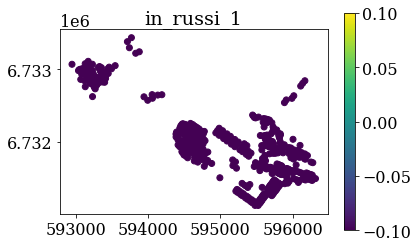

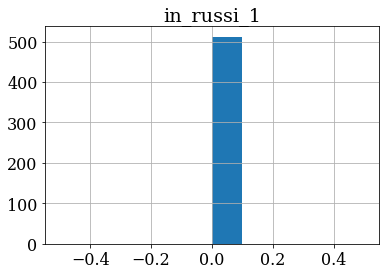

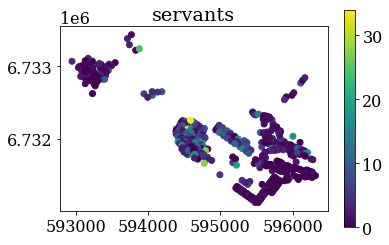

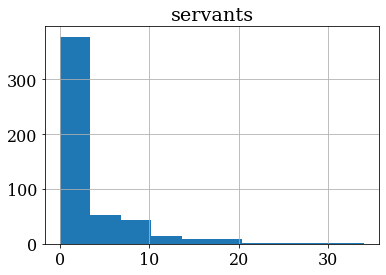

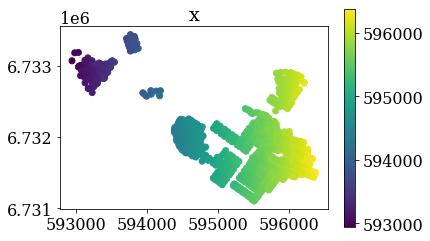

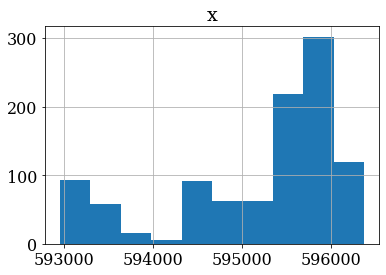

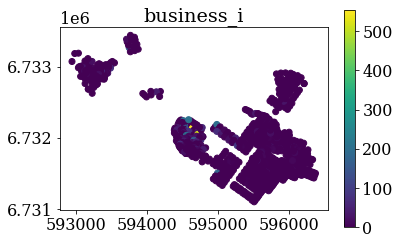

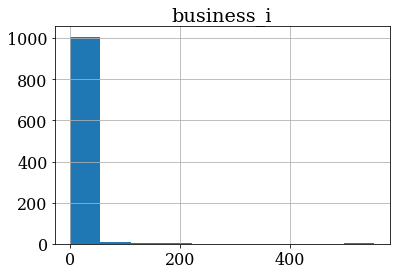

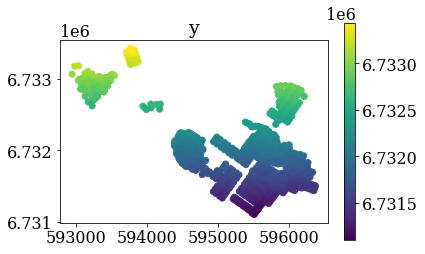

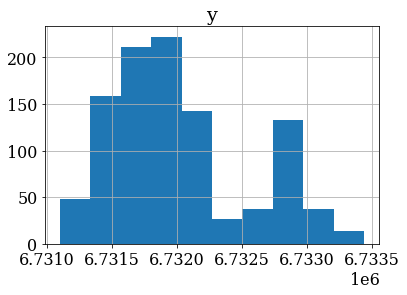

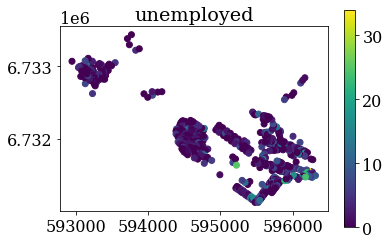

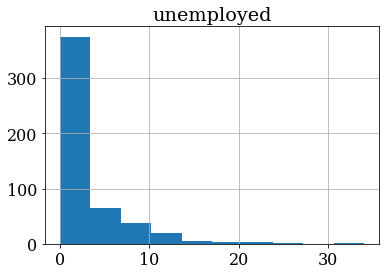

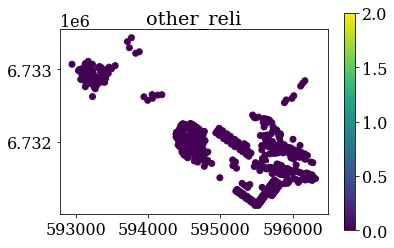

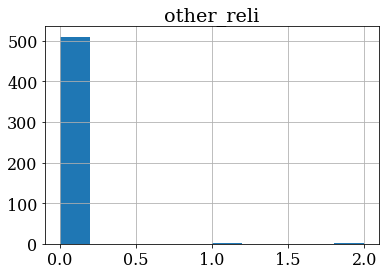

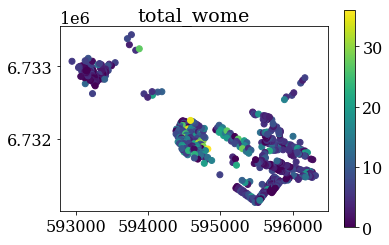

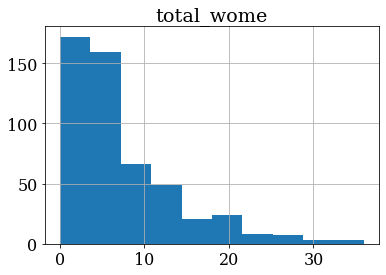

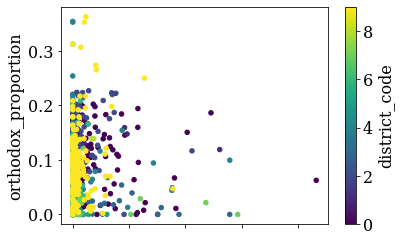

In [3]:
# your code for building the model
# and doing the inference

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

data = gpd.read_file('spatial_income_1880.shp')
data['orthodox_proportion'] = data.orthodox_d / data.total_dens
data['income_per_person'] = data.total_inco / data.total_dens
data.income_per_person = data.income_per_person.apply(lambda w: w if 0 <= w <= 10 else np.nan)

for c in set(data.columns) - {'geometry', 'district', 'plot_numbe'}:
    data.plot(column=c, legend=True)
    plt.title(c)
    data.hist(c)

aspatial_data = pd.DataFrame(data, index=data.index)
aspatial_data['district_code'] = aspatial_data.district.factorize()[0]
aspatial_data.plot(x='income_per_person', y='orthodox_proportion', kind='scatter', c='district_code', colormap='viridis')
aspatial_data.to_csv('data.csv')

In [4]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import arviz as az
import matplotlib.pyplot as plt

aspatial_data = pd.read_csv('data.csv', index_col=0).dropna(axis=0)
data = aspatial_data#.loc[aspatial_data.district == 'Valli', :]

with pm.Model() as model:
    alpha_S = 1
    beta_S = 3
    S_d = pm.Beta('S_d', alpha_S, beta_S)
    mu_W = 2
    lambda_W = 1/mu_W
    W_k = pm.Exponential('W_k', lambda_W, observed=data.income_per_person)
    mu_beta = np.array([0., 0., 0., 0.,])
    sigma_beta = np.array(np.diagflat([0.2, 0.2, 0.2, 0.2,]))
    beta = pm.MvNormal('beta', mu_beta, sigma_beta, shape=4)
    mu_O = np.exp(beta[0] + beta[1] * W_k + beta[2] * S_d + beta[3] * W_k * S_d)
    alpha_O = 0.2
    O_k = pm.NegativeBinomial('O_k', mu_O, alpha_O, observed=data.orthodox_proportion)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.94)
pm.model_to_graphviz(model)

ImportError: cannot import name 'is_same_graph' from 'theano.gof.toolbox' (C:\Users\antth\Anaconda3\envs\bayes\lib\site-packages\theano\gof\toolbox.py)

## Experiment

### Experiments setup

### Results

## Discussion and conclusion